# **Sentiment Analysis and Text Generation**

## **Problem Overview**

Exploring Sentiment analysis and text generation using many-to-one Long Short-Term Memory (LSTM) neural networks.

Sentiment Detection:
Diving into sentiment analysis by training an LSTM model to analyze airline sentiments. The dataset consists of sentiment labels (0 or 1) and corresponding text reviews. Preprocess the data, converting it into a numerical representation using the bag-of-words technique. Through the many-to-one LSTM architecture, predicting sentiment labels based on the textual input.

Text Generation:
Next, venturing into the realm of text generation. Using the beloved classic "Alice's Adventures in Wonderland" as training text, prepare and structure the data to facilitate the training of many-to-one LSTMs. These LSTMs will learn the patterns and sequences in the text, enabling us to generate new text based on a given prompt. Focus is specifically on next-word prediction, allowing us to generate coherent and contextually relevant sentences.

To overcome challenges of text generation, including the dynamic nature of language and the presence of multiple words with similar meanings, i will utilize techniques such as entropy scaling and softmax temperature. By adjusting the temperature parameter, we can control the randomness and diversity of the generated text.

## **Steps**

* Sentiment Analysis:

    * Dataset:
        * Obtain the airline sentiment dataset consisting of sentiment labels (0 or 1) and corresponding text reviews.

    * Preprocessing:
        * Perform data preprocessing tasks, including text cleaning, tokenization, and removing stop words.
        * Convert the text reviews into a bag-of-words representation.

    * Many-to-One LSTM:
        * Utilize many-to-one LSTM architecture to train the sentiment detection model.
        * Feed the bag-of-words representation of the text reviews as input to the LSTM.

    * Training:
        * Split the dataset into training and testing sets.
        * Train the LSTM model using the training set.
        * Evaluate the model's performance on the testing set.

* Text Generation:

    * Dataset:
        * Obtain the "Alice's Adventures in Wonderland" text dataset.

    * Preparing and Structuring:
        * Preprocess the text data by cleaning, tokenizing, and structuring the sentences and phrases.
        * Create sequences

    * Many-to-One LSTM:
        * Implement many-to-one LSTM architecture for text generation.
        * Train the LSTM model using the prepared dataset.

    * The Problem with Text Generation:
        * Understand the challenges associated with text generation, such as the variability of language and the dependence on context, style, and word choice.
        * Recognize that natural language utilizes a wide variety of words, which may have similar meanings and require careful consideration during generation.

    * Randomness through Entropy Scaling:
        * Explore the concept of entropy scaling to introduce controlled randomness into text generation.

    * Softmax Temperature:
        * Introduce the concept of softmax temperature, a hyperparameter used to control the randomness of predictions in LSTMs and neural networks.
        * Predicting using the Temperature


## **Install Packages**


In [117]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [118]:
#!pip install tensorflow
#!pip install numpy
#!pip install pandas
#!pip install nltk

### **Import Libraries**

In [119]:
# import relevant packages
import os
from collections import Counter

import tensorflow as tf
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.utils import to_categorical, pad_sequences
from keras.layers import Embedding

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import nltk
import re

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [120]:
pd.set_option('display.max_colwidth', None)
tf.keras.backend.set_image_data_format("channels_last")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Sentiment Detection with (Many to One) LSTM**

## **Reading the dataset**

In [121]:
## We are using the data by mounting the google drive, hence using the following :
from google.colab import drive
drive.mount("/content/drive/")
!ls
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/airline_sentiment.csv')
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
drive  sample_data


,airline_sentiment,text
0,1,@AmericanAirlines plus you've added commercials to the experience... tacky.
1,0,"@AmericanAirlines it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
2,0,@AmericanAirlines and it's a really big bad thing about it
3,0,@AmericanAirlines seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
4,1,"@AmericanAirlines yes, nearly every time I fly VX this “ear worm” won’t go away :)"


## **Pre Processing data for training**

- Normalise sentences: remove special characters, convert to lower case etc.
- Remove stop words to give more relevance to specific words

In [122]:
# Loading English stop words
stop = nltk.corpus.stopwords.words('english')

In [123]:
def pre_process_text_data(text: str) -> str:
    # normalize and remove special characters
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]+',' ',text)
    # remove stop words
    words = text.split()
    words = [w for w in words if (w not in stop)]
    words = ' '.join(words)
    return words

In [124]:
df['text'] = df['text'].apply(pre_process_text_data)
df.head()

,airline_sentiment,text
0,1,americanairlines plus added commercials experience tacky
1,0,americanairlines really aggressive blast obnoxious entertainment guests faces amp little recourse
2,0,americanairlines really big bad thing
3,0,americanairlines seriously would pay 30 flight seats playing really bad thing flying va
4,1,americanairlines yes nearly every time fly vx ear worm go away


## **Checking most used words**

In [125]:
counts = Counter()
for i, review in enumerate(df['text']):
    counts.update(review.split())

In [126]:
words = sorted(counts, key=counts.get, reverse=True)
words[0:10]

['united',
 'flight',
 'usairways',
 'americanair',
 'southwestair',
 'jetblue',
 'get',
 'cancelled',
 'thanks',
 'service']

## **Creating numeric representation of words (Bag of Words)**

The bag-of-words representation is a technique used to convert text data into a numerical representation that can be used for machine learning algorithms. It disregards the order and structure of words in a sentence and focuses solely on the frequency of occurrence of words.


In [127]:
word_to_int = {word: i for i, word in enumerate(words, start=1)}
int_to_word = {i: word for i, word in enumerate(words, start=1)}

In [128]:
def text_to_int(text:str, word_to_int: dict):
    return [word_to_int[word] for word in review.split()]


def int_to_text(int_arr, int_to_word: dict):
    return ' '.join([int_to_word[index] for index in int_arr if index != 0])

In [129]:
mapped_reviews = []
for review in df['text']:
    mapped_reviews.append(text_to_int(review, word_to_int))

In [130]:
print(f'Original text: {df.loc[0]["text"]}')
print(f'Mapped text: {mapped_reviews[0]}')

Original text: americanairlines plus added commercials experience tacky
Mapped text: [40, 450, 1141, 2232, 100, 5428]


In [131]:
length_sent = []
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))


## **Checking sequence length and padding accordingly**

In [132]:
sequence_length = max(length_sent)
X = pad_sequences(maxlen = sequence_length,
                  sequences = mapped_reviews,
                  padding = "post",
                  value = 0)

In [133]:
X[0]

array([  40,  450, 1141, 2232,  100, 5428,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [134]:
y = df['airline_sentiment'].values

## **Creating LSTM Model**

In [135]:
embedding_vecor_length = 32
max_review_length = 26

In [136]:
model = Sequential()
model.add(Embedding(input_dim=12533, output_dim=32, input_length = 26))
model.add(LSTM(40, return_sequences=True))
model.add(LSTM(40, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [137]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 32)            401056    
                                                                 
 lstm_6 (LSTM)               (None, 26, 40)            11680     
                                                                 
 lstm_7 (LSTM)               (None, 40)                12960     
                                                                 
 dense_4 (Dense)             (None, 2)                 82        
                                                                 
Total params: 425778 (1.62 MB)
Trainable params: 425778 (1.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## **Preparing data for training and validation**

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)


## **One-hot-encoding**

In [139]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## **Training**

In [140]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
253/253 [==============================] - 15s 44ms/step - loss: 0.3247 - accuracy: 0.8706 - val_loss: 0.2417 - val_accuracy: 0.9047
Epoch 2/50
253/253 [==============================] - 8s 31ms/step - loss: 0.1433 - accuracy: 0.9480 - val_loss: 0.2590 - val_accuracy: 0.9174
Epoch 3/50
253/253 [==============================] - 7s 29ms/step - loss: 0.0744 - accuracy: 0.9749 - val_loss: 0.2907 - val_accuracy: 0.9070
Epoch 4/50
253/253 [==============================] - 7s 29ms/step - loss: 0.0445 - accuracy: 0.9874 - val_loss: 0.2862 - val_accuracy: 0.9056
Epoch 5/50
253/253 [==============================] - 8s 31ms/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.3428 - val_accuracy: 0.9004
Epoch 6/50
253/253 [==============================] - 7s 29ms/step - loss: 0.0227 - accuracy: 0.9936 - val_loss: 0.4123 - val_accuracy: 0.9076
Epoch 7/50
253/253 [==============================] - 7s 29ms/step - loss: 0.0205 - accuracy: 0.9943 - val_loss: 0.3838 - val_accuracy: 0.902

In [141]:
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

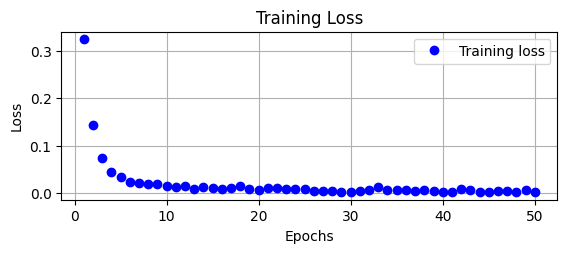

In [142]:
plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

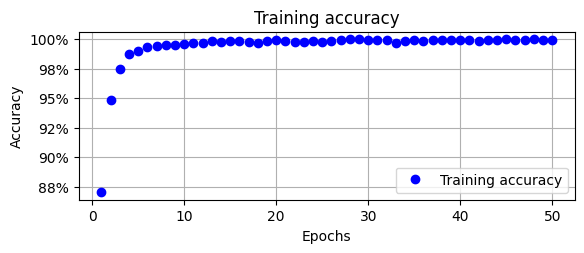

In [143]:
plt.subplot(212)
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

## **Anecdotes**

In [144]:
def get_sentiment(model, text) -> str:
    text_int_embedding = text_to_int(text, word_to_int)
    text_int_embedding = pad_sequences(maxlen = sequence_length,
                                       sequences = [text_int_embedding],
                                       padding = "post", value = 0)
    sentiment_index = np.argmax(model.predict(text_int_embedding))
    return sentiment_index

In [145]:
result = np.argmax(model.predict(X_test), axis=1)

109/109 [==============================] - 2s 8ms/step


In [146]:
positive_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 1]

In [147]:
negative_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 0]

In [148]:
positive_sentences[:5]

['jetblue flight flight booking problems experience pretty great',
 'americanair well done taken fun air travel phlairport',
 'jetblue going bdl dca flights yesterday today every single one getting delayed',
 'southwestair leeannhealey yeah sale fares got places fly oh damn right live swa fly',
 'jetblue news gate options']

In [149]:
negative_sentences[:5]

['usairways glad airline going swallowed american american always picks phone solves problems',
 'southwestair disconnected call 2 5 hours without even speaking octaviannightmare',
 'usairways told coded upgrade clearly purchased seat miles refuse downgrade ripoff',
 'rt americanairlines met match got status another airline upgrade restr http co rhkamx9vf5 http co pyalebgkjt',
 'southwestair receive bad customer service ended spending several hundred dollars accommodate family cxl flight']

## **Generating Text**

The strategy that we'll adopt to generate text is as follows:

1. Import project Gutenberg's Alice's Adventures in Wonderland dataset, which can be downloaded from https://www.gutenberg.org/files/11/11-0.txt.
2. Preprocess the text data so that we bring every word to the same case, and remove punctuation.
3. Build and train a model, by performing embedding on top of the input word IDs and then connecting the embeddings to an LSTM, which is connected to the output layer through a hidden layer. The value in the output layer is the one-hot-encoded version of the output.
6. Make a prediction for the subsequent word by taking a random location of word and consider the historical words prior to the location of the random word chosen.
7. Move the window of the input words by one from the seed word's location that we chose earlier and the tenth time step word shall be the word that we predicted in the previous step

In [150]:
def load_data(filename: str = 'drive/MyDrive/Colab Notebooks/data/alice.txt'):
    with open(filename, encoding='utf-8-sig') as fin:
        lines = []
        for line in fin:
            line = line.strip().lower()
            if (len(line) == 0):
                continue
            lines.append(line)
        fin.close()
        text = " ".join(lines)
    return text

In [151]:
text = load_data()

In [152]:
text[3001:3500]

'moment to think about stopping herself before she found herself falling down a very deep well. either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next. first, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps '

Normalize the text to remove punctuations and convert it to lowercase



In [153]:
def pre_process(text: str) -> str:
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

Assign the unique words to an index so that they can be referenced when constructing the training and test datasets

In [154]:
counts = Counter()
counts.update(text.split())

words = sorted(counts, key=counts.get, reverse=True)
nb_words = len(text.split())

word2index = {word: i for i, word in enumerate(words)}
index2word = {i: word for i, word in enumerate(words)}

### Preparing the Data

In [155]:
SEQLEN = 10
STEP = 1

Construct the input set of words that leads to an output word. Note that we are considering a sequence of 10 words and trying to predict the 11th word


In [156]:
def get_input_and_labels(text: str,
                         seq_length: int = SEQLEN,
                         step: int = STEP):

    input_words = []
    label_words = []

    text_arr = text.split()

    for i in range(0, nb_words-seq_length, step):
        x = text_arr[i:(i+seq_length)]
        y = text_arr[i+seq_length]
        input_words.append(x)
        label_words.append(y)

    return input_words, label_words

In [157]:
input_words, label_words = get_input_and_labels(text)

In [158]:
print(f'Input: {" ".join(input_words[0])}\nOutput: {label_words[0]}')

Input: the project gutenberg ebook of alice’s adventures in wonderland, by
Output: lewis


Construct the vectors of the input and the output datasets:

In [159]:
total_words = len(set(words))

X = np.zeros((len(input_words), SEQLEN, total_words), dtype= bool)
y = np.zeros((len(input_words), total_words), dtype=bool)

We are creating empty arrays in the preceding step, which will be populated in the following code:

In [160]:
# Create encoded vectors for the input and output values
for i, input_word in enumerate(input_words):
    for j, word in enumerate(input_word):
        X[i, j, word2index[word]] = 1
        y[i, word2index[label_words[i]]] = 1

In [161]:
print(f'Input of X: {X.shape}\nInput of y: {y.shape}')

Input of X: (29584, 10, 5649)
Input of y: (29584, 5649)


### Defining the Model

In [162]:
HIDDEN_SIZE = 128
BATCH_SIZE = 32
NUM_ITERATIONS = 100
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

In [163]:
model = Sequential()

model.add(LSTM(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, total_words)))
model.add(Dense(total_words, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               2958336   
                                                                 
 dense_5 (Dense)             (None, 5649)              728721    
                                                                 
Total params: 3687057 (14.07 MB)
Trainable params: 3687057 (14.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fit the model**.
- Look at how the output varies over an increasing number of epochs.
- Generate a random set of sequences of 10 words and try to predict the next possible word.
- We are in a position to observe how our predictions are getting better over an increasing number of epochs

In [164]:
def check_model_output(model, preds: int, input_words, seq_length, total_words):
    test_idx = np.random.randint(int(len(input_words)*0.1)) * (-1)
    test_words = input_words[test_idx]

    for curr_pred in range(preds):
        curr_embedding = np.zeros((1, seq_length, total_words))

        for i, ch in enumerate(test_words):
            curr_embedding[0, i, word2index[ch]] = 1

        pred = model.predict(curr_embedding, verbose=0)[0]
        word_pred = index2word[np.argmax(pred)]

        print("=" * 50)
        print(f"Prediction {curr_pred + 1} of {preds}")
        print(f'Generating from seed: {" ".join(test_words)}\nNext Word: {word_pred}')
        print("=" * 50)

        test_words = test_words[1:] + [word_pred]

In [165]:
for iteration in range(10):
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION, validation_split = 0.1)
    if iteration % 100 == 0:
        check_model_output(model, 5, input_words, SEQLEN, total_words)


833/833 [==============================] - 54s 62ms/step - loss: 7.0166 - val_loss: 8.2516
Prediction 1 of 5
Generating from seed: gutenberg literary archive foundation are tax deductible to the full
Next Word: the
Prediction 2 of 5
Generating from seed: literary archive foundation are tax deductible to the full the
Next Word: the
Prediction 3 of 5
Generating from seed: archive foundation are tax deductible to the full the the
Next Word: the
Prediction 4 of 5
Generating from seed: foundation are tax deductible to the full the the the
Next Word: the
Prediction 5 of 5
Generating from seed: are tax deductible to the full the the the the
Next Word: the
833/833 [==============================] - 49s 59ms/step - loss: 2.4681 - val_loss: 12.0575


In [166]:
def predict_next_word(model, input_text: str, seq_length, total_words, temperature = None):
    curr_embedding = np.zeros((1, seq_length, total_words))

    for i, ch in enumerate(input_text):
        curr_embedding[0, i, word2index[ch]] = 1

    pred = model.predict(curr_embedding, verbose=0)[0]

    if temperature == None:
        word_pred = index2word[np.argmax(pred)]
    else:
        next_word_token = tf.random.categorical(tf.expand_dims(pred / temperature, 0), num_samples=1)[-1, 0].numpy()
        word_pred = index2word[next_word_token]

    return pred, word_pred

## **The Problem with Text Generation**

Language is not always the same and/or stationary, the next word to predict depends on the context, style and etc. Therefore, natural language, uses a wide variety of words, sometimes, with same meaning

Lets have a look:

In [167]:
test_words = input_words[-28701]
print(' '.join(test_words))

among the people that walk with their heads downward! the


In [168]:
logits, word_pred = predict_next_word(model, test_words, SEQLEN, total_words)

In [169]:
print(f'Predicted word: {word_pred}')

Predicted word: world


In [170]:
def generate_paragraph(model, seed, words: int, temperature: int):
    full_text = seed.copy()
    for _ in range(words):
        logits, word_pred = predict_next_word(model, seed, SEQLEN, total_words, temperature=temperature)
        seed = (seed + [word_pred])[-10:]
        full_text = full_text + [word_pred]
    return full_text

In [171]:
for _ in range(5):
    print(' '.join(generate_paragraph(model, test_words, 12, None)))

among the people that walk with their heads downward! the world i hadn’t me me a dear is is a poor alice
among the people that walk with their heads downward! the world i hadn’t me me a dear is is a poor alice
among the people that walk with their heads downward! the world i hadn’t me me a dear is is a poor alice
among the people that walk with their heads downward! the world i hadn’t me me a dear is is a poor alice
among the people that walk with their heads downward! the world i hadn’t me me a dear is is a poor alice


## **Randomness through Entropy Scaling**

In [172]:
sorted(logits, reverse=True)[:5]

[0.07793151, 0.06722314, 0.045783, 0.023944052, 0.021414362]

## Softmax Temperature

Temperature is a hyperparameter of LSTMs (and neural networks generally) used to control the randomness of predictions by scaling the logits before applying softmax. Temperature scaling has been widely used to improve performance for NLP tasks that utilize the Softmax decision layer

## Predicting using the Temperature

In [173]:
for _ in range(5):
    print(' '.join(generate_paragraph(model, test_words, 12, 10)))

among the people that walk with their heads downward! the seated mouth king eyes banquet—] fancying all,” _that_. itself. join rushed flapper
among the people that walk with their heads downward! the creatures, least comply day—” “behead fix respect. tumbled speech, suppressed stop.” do:—
among the people that walk with their heads downward! the alteration, court. mean,” pence. nile cats.” millennium stairs. face—and bread-and-butter. linked frog
among the people that walk with their heads downward! the did,” “don’t _what?_” ring, things! to? stop above passage, court!” shoulders, “beautiful
among the people that walk with their heads downward! the remark. warranty questions, “stand near. learn bathing hatter pigeon. afterwards, she’ll cheerfully
